# Stock Market Prediction using Numerical and Textual Analysis 
### (Using Stacked LSTM)


##  Qualcomm Stock Price Data | Financial News Headlines Data

In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
# reading the datasets into pandas

n_2015 = pd.read_csv('Headlines_2015.csv')
n_2016 = pd.read_csv('Headlines_2016.csv')
n_2017 = pd.read_csv('Headlines_2017.csv')
n_2018 = pd.read_csv('Headlines_2018.csv')
n_2019 = pd.read_csv('Headlines_2019.csv')
n_2020 = pd.read_csv('Headlines_2020.csv')
n_2021 = pd.read_csv('Headlines_2021.csv')


stock_price= pd.read_csv('HistoricalData_QCOM.csv')
stock_headlines = pd.concat([n_2015,n_2016,n_2017,n_2018,n_2019,n_2020,n_2021], axis=0)


In [3]:
# displaying stock price dataset
stock_price.head()

,Date,Close/Last,Volume,Open,High,Low
0,06/09/2021,$132.89,6717243,$135.105,$135.35,$132.79
1,06/08/2021,$134.2,9657889,$134.06,$135.3895,$133
2,06/07/2021,$133.32,5563253,$133.7,$133.77,$132.64
3,06/04/2021,$134.34,7416675,$132.525,$135.05,$132.2
4,06/03/2021,$131.78,6643997,$132.65,$133.39,$131.42


In [4]:
# displaying stock news headlines dataset
stock_headlines.head()

,Date,Headlines
0,2015-01-01,What Can We Expect From Apple Inc. In 2015? 1 ...
1,2015-01-02,What to expect from Apple in 2015 beyond its s...
2,2015-01-03,Mountie: An inexpensive and innovative way to ...
3,2015-01-04,"Donald Yacktman on the Sources of Moats, His C..."
4,2015-01-05,"SIM-free iPhone 6, 6 Plus reportedly debuting ..."


## 2 Feature Engineering

In [5]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [6]:
#converting the date column from object to timeformat

stock_price['Date'] = pd.to_datetime(stock_price['Date'])

In [7]:
#Removing the '$' sign from the data and converting the prices into float value

stock_price['Close/Last'] = stock_price['Close/Last'].str.replace('$','').astype(float)
stock_price['Open'] = stock_price['Open'].str.replace('$','').astype(float)
stock_price['High'] = stock_price['High'].str.replace('$','').astype(float)
stock_price['Low'] = stock_price['Low'].str.replace('$','').astype(float)

In [8]:
#renaming the Column for a better presentation 

stock_price.rename(columns={'Close/Last':'Close'},inplace= True)

In [9]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2516 non-null   datetime64[ns]
 1   Close   2516 non-null   float64       
 2   Volume  2516 non-null   int64         
 3   Open    2516 non-null   float64       
 4   High    2516 non-null   float64       
 5   Low     2516 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


In [10]:
stock_price.head()

,Date,Close,Volume,Open,High,Low
0,2021-06-09,132.89,6717243,135.105,135.3500,132.79
1,2021-06-08,134.20,9657889,134.060,135.3895,133.00
2,2021-06-07,133.32,5563253,133.700,133.7700,132.64
3,2021-06-04,134.34,7416675,132.525,135.0500,132.20
4,2021-06-03,131.78,6643997,132.650,133.3900,131.42


In [11]:
stock_headlines.head()

,Date,Headlines
0,2015-01-01,What Can We Expect From Apple Inc. In 2015? 1 ...
1,2015-01-02,What to expect from Apple in 2015 beyond its s...
2,2015-01-03,Mountie: An inexpensive and innovative way to ...
3,2015-01-04,"Donald Yacktman on the Sources of Moats, His C..."
4,2015-01-05,"SIM-free iPhone 6, 6 Plus reportedly debuting ..."


In [12]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(2516, 2365)

In [13]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date      False
 Close     False
 Volume    False
 Open      False
 High      False
 Low       False
 dtype: bool,
 Date         False
 Headlines    False
 dtype: bool)

### 2.1 Stock Price Data

In [14]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2011-06-10,54.60,55.700,55.7400,54.355,14524760
2011-06-13,54.40,54.790,54.8900,54.240,10670650
2011-06-14,55.58,54.870,55.8700,54.750,11995730
2011-06-15,54.10,55.230,55.5600,53.800,16748740
2011-06-16,52.99,54.120,54.2100,52.420,19440800
...,...,...,...,...,...
2021-06-03,131.78,132.650,133.3900,131.420,6643997
2021-06-04,134.34,132.525,135.0500,132.200,7416675
2021-06-07,133.32,133.700,133.7700,132.640,5563253


### 2.2 Stock News Headlines Data

In [15]:
stock_headlines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2365 entries, 0 to 173
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       2365 non-null   object
 1   Headlines  2365 non-null   object
dtypes: object(2)
memory usage: 55.4+ KB


In [16]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

In [17]:
stock_headlines['Date'] = pd.to_datetime(stock_headlines['Date'])

In [18]:
stock_headlines['Date'] = pd.to_datetime(stock_headlines['Date']).dt.normalize()

In [19]:
stock_headlines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2342 entries, 0 to 173
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2342 non-null   datetime64[ns]
 1   Headlines  2342 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 54.9+ KB


In [20]:
# filtering the important columns required
stock_headlines = stock_headlines.filter(['Date', 'Headlines'])

In [21]:
# setting column 'Date' as the index column
stock_headlines.set_index('Date',inplace= True)

In [22]:
# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['Date'])['Headlines'].apply(lambda x: ','.join(x)).reset_index()


# setting column 'Date' as the index column
stock_headlines.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,Headlines
Date,
2015-01-01,What Can We Expect From Apple Inc. In 2015? 1 ...
2015-01-02,What to expect from Apple in 2015 beyond its s...
2015-01-03,Mountie: An inexpensive and innovative way to ...
2015-01-04,"Donald Yacktman on the Sources of Moats, His C..."
2015-01-05,"SIM-free iPhone 6, 6 Plus reportedly debuting ..."
...,...
2021-06-19,Best pre-Prime Day smartwatch deals on Apple W...
2021-06-20,iPhone 13 rumors: As Apple's fall event gets c...
2021-06-21,Apple is shortening new free TV Plus trials fr...


In [23]:
stock_headlines.head()

,Headlines
Date,
2015-01-01,What Can We Expect From Apple Inc. In 2015? 1 ...
2015-01-02,What to expect from Apple in 2015 beyond its s...
2015-01-03,Mountie: An inexpensive and innovative way to ...
2015-01-04,"Donald Yacktman on the Sources of Moats, His C..."
2015-01-05,"SIM-free iPhone 6, 6 Plus reportedly debuting ..."


### 2.3 Combined Stock Data

In [24]:
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2011-06-10,54.60,55.700,55.7400,54.355,14524760
2011-06-13,54.40,54.790,54.8900,54.240,10670650
2011-06-14,55.58,54.870,55.8700,54.750,11995730
2011-06-15,54.10,55.230,55.5600,53.800,16748740
2011-06-16,52.99,54.120,54.2100,52.420,19440800
...,...,...,...,...,...
2021-06-03,131.78,132.650,133.3900,131.420,6643997
2021-06-04,134.34,132.525,135.0500,132.200,7416675
2021-06-07,133.32,133.700,133.7700,132.640,5563253


In [25]:
stock_headlines

,Headlines
Date,
2015-01-01,What Can We Expect From Apple Inc. In 2015? 1 ...
2015-01-02,What to expect from Apple in 2015 beyond its s...
2015-01-03,Mountie: An inexpensive and innovative way to ...
2015-01-04,"Donald Yacktman on the Sources of Moats, His C..."
2015-01-05,"SIM-free iPhone 6, 6 Plus reportedly debuting ..."
...,...
2021-06-19,Best pre-Prime Day smartwatch deals on Apple W...
2021-06-20,iPhone 13 rumors: As Apple's fall event gets c...
2021-06-21,Apple is shortening new free TV Plus trials fr...


In [26]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0,inplace=True)

In [27]:
stock_data

,Close,Open,High,Low,Volume,Headlines
Date,,,,,,
2015-01-02,74.280,74.510,74.8699,73.75,6666213.0,What to expect from Apple in 2015 beyond its s...
2015-01-05,73.930,73.710,74.5000,73.63,12027610.0,"SIM-free iPhone 6, 6 Plus reportedly debuting ..."
2015-01-06,72.880,73.860,74.6100,72.74,11080410.0,"Technology Transforming Cars Into ""Phones On W..."
2015-01-07,73.730,73.370,74.4700,72.96,10025470.0,Apple issues fourth developer beta of OS X 10....
2015-01-08,74.505,74.300,75.3000,74.14,10926270.0,Apple company recalls 2014 shipments after lin...
...,...,...,...,...,...,...
2021-06-03,131.780,132.650,133.3900,131.42,6643997.0,Buy RH Stock on the Dip Before Q1 Earnings for...
2021-06-04,134.340,132.525,135.0500,132.20,7416675.0,"Global equities nearly grasp all-time record, ..."
2021-06-07,133.320,133.700,133.7700,132.64,5563253.0,Apple&quot;s new &quot;private relay&quot; fea...


In [28]:
# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,Headlines
Date,,,,,,
2015-01-02,74.280,74.510,74.8699,73.75,6666213.0,What to expect from Apple in 2015 beyond its s...
2015-01-05,73.930,73.710,74.5000,73.63,12027610.0,"SIM-free iPhone 6, 6 Plus reportedly debuting ..."
2015-01-06,72.880,73.860,74.6100,72.74,11080410.0,"Technology Transforming Cars Into ""Phones On W..."
2015-01-07,73.730,73.370,74.4700,72.96,10025470.0,Apple issues fourth developer beta of OS X 10....
2015-01-08,74.505,74.300,75.3000,74.14,10926270.0,Apple company recalls 2014 shipments after lin...
...,...,...,...,...,...,...
2021-06-03,131.780,132.650,133.3900,131.42,6643997.0,Buy RH Stock on the Dip Before Q1 Earnings for...
2021-06-04,134.340,132.525,135.0500,132.20,7416675.0,"Global equities nearly grasp all-time record, ..."
2021-06-07,133.320,133.700,133.7700,132.64,5563253.0,Apple&quot;s new &quot;private relay&quot; fea...


### 2.4 Calculating Sentiment Scores

In [29]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,Headlines,compound,negative,neutral,positive
Date,,,,,,,,,,
2015-01-02,74.280,74.51,74.8699,73.75,6666213.0,What to expect from Apple in 2015 beyond its s...,,,,
2015-01-05,73.930,73.71,74.5000,73.63,12027610.0,"SIM-free iPhone 6, 6 Plus reportedly debuting ...",,,,
2015-01-06,72.880,73.86,74.6100,72.74,11080410.0,"Technology Transforming Cars Into ""Phones On W...",,,,
2015-01-07,73.730,73.37,74.4700,72.96,10025470.0,Apple issues fourth developer beta of OS X 10....,,,,
2015-01-08,74.505,74.30,75.3000,74.14,10926270.0,Apple company recalls 2014 shipments after lin...,,,,


In [30]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,Headlines,compound,negative,neutral,positive
Date,,,,,,,,,,
2015-01-02,74.280,74.51,74.8699,73.75,6666213.0,What to expect from Apple in 2015 beyond its s...,0.9881,0.041,0.849,0.110
2015-01-05,73.930,73.71,74.5000,73.63,12027610.0,"SIM-free iPhone 6, 6 Plus reportedly debuting ...",0.9973,0.022,0.843,0.134
2015-01-06,72.880,73.86,74.6100,72.74,11080410.0,"Technology Transforming Cars Into ""Phones On W...",0.6189,0.049,0.897,0.055
2015-01-07,73.730,73.37,74.4700,72.96,10025470.0,Apple issues fourth developer beta of OS X 10....,-0.8334,0.074,0.865,0.062
2015-01-08,74.505,74.30,75.3000,74.14,10926270.0,Apple company recalls 2014 shipments after lin...,0.9973,0.039,0.832,0.129


## 3 Finalising Stock Data and writing to Disk

In [31]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['Headlines'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,74.280,0.9881,0.041,0.849,0.110,74.51,74.8699,73.75,6666213.0
2015-01-05,73.930,0.9973,0.022,0.843,0.134,73.71,74.5000,73.63,12027610.0
2015-01-06,72.880,0.6189,0.049,0.897,0.055,73.86,74.6100,72.74,11080410.0
2015-01-07,73.730,-0.8334,0.074,0.865,0.062,73.37,74.4700,72.96,10025470.0
2015-01-08,74.505,0.9973,0.039,0.832,0.129,74.30,75.3000,74.14,10926270.0


In [32]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

## 4 Reading Stock Data 

In [33]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,74.280,0.9881,0.041,0.849,0.110,74.51,74.8699,73.75,6666213.0
2015-01-05,73.930,0.9973,0.022,0.843,0.134,73.71,74.5000,73.63,12027610.0
2015-01-06,72.880,0.6189,0.049,0.897,0.055,73.86,74.6100,72.74,11080410.0
2015-01-07,73.730,-0.8334,0.074,0.865,0.062,73.37,74.4700,72.96,10025470.0
2015-01-08,74.505,0.9973,0.039,0.832,0.129,74.30,75.3000,74.14,10926270.0


## 5 Feature Engineering of Stock Data

In [34]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(1597, 9)

In [35]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [36]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1.597000e+03
mean,73.528140,0.713653,0.057204,0.838366,0.104444,73.541387,74.411803,72.658269,1.168884e+07
std,26.943508,0.607581,0.027465,0.037541,0.030716,27.014350,27.380880,26.547120,8.189657e+06
min,42.960000,-0.999600,0.000000,0.694000,0.000000,42.510000,43.290000,42.240000,2.120165e+06
25%,55.400000,0.897100,0.039000,0.816000,0.084000,55.580000,56.150000,54.990000,7.493471e+06
50%,65.200000,0.984000,0.053000,0.841000,0.102000,65.190000,65.929900,64.450000,9.775404e+06
75%,77.520000,0.995400,0.071000,0.863000,0.124000,77.270000,78.700000,76.170000,1.316857e+07
max,164.780000,0.999700,0.237000,0.975000,0.256000,167.577000,167.940000,164.440000,1.559539e+08


In [37]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1597 entries, 2015-01-02 to 2021-06-09
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     1597 non-null   float64
 1   compound  1597 non-null   float64
 2   negative  1597 non-null   float64
 3   neutral   1597 non-null   float64
 4   positive  1597 non-null   float64
 5   Open      1597 non-null   float64
 6   High      1597 non-null   float64
 7   Low       1597 non-null   float64
 8   Volume    1597 non-null   float64
dtypes: float64(9)
memory usage: 124.8+ KB


## 6 EDA of Stock Data

Text(0, 0.5, 'Close Price ($)')

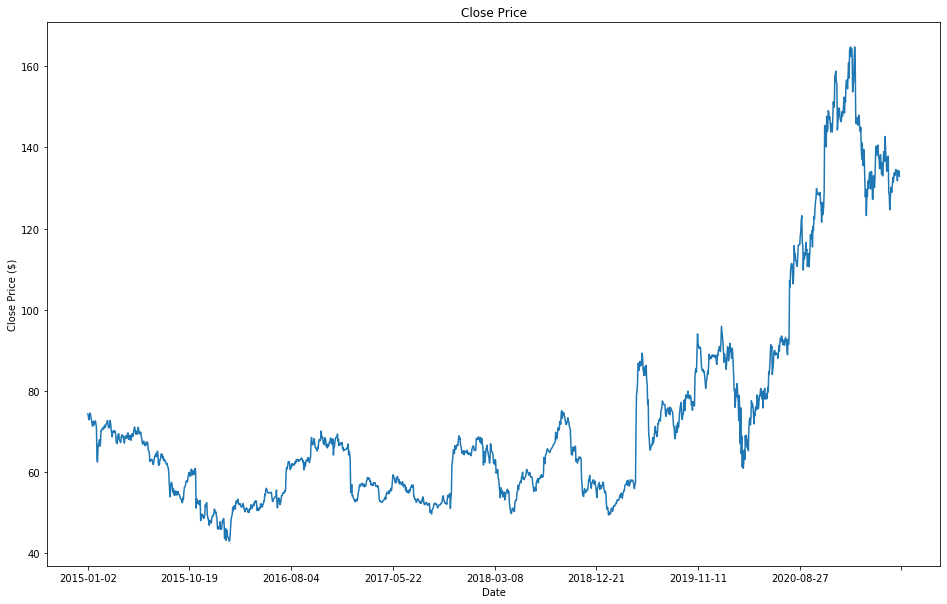

In [38]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [39]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-12,73.902143,0.680314,0.052000,0.833143,0.115000,74.065714,74.714257,73.391429,9.781201e+06
2015-01-13,73.715000,0.681886,0.050000,0.826571,0.123571,73.987143,74.739986,73.220000,1.062667e+07
2015-01-14,73.470714,0.678386,0.057286,0.824571,0.118429,73.808571,74.525700,72.907143,1.079465e+07


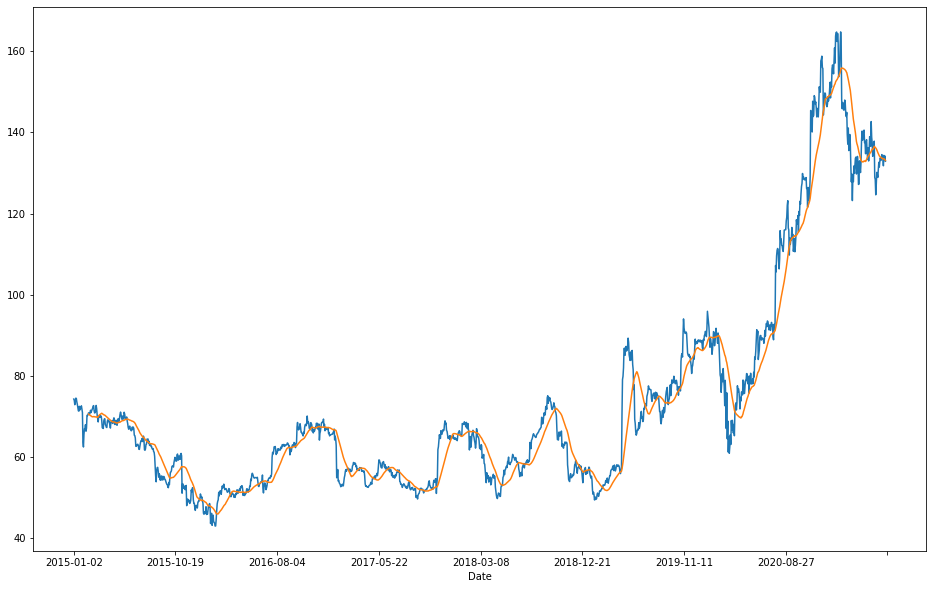

In [40]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [41]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,74.280,0.9881,0.041,0.849,0.110,74.510,74.8699,73.75,6666213.0
2015-01-05,73.930,0.9973,0.022,0.843,0.134,73.710,74.5000,73.63,12027610.0
2015-01-06,72.880,0.6189,0.049,0.897,0.055,73.860,74.6100,72.74,11080410.0
2015-01-07,73.730,-0.8334,0.074,0.865,0.062,73.370,74.4700,72.96,10025470.0
2015-01-08,74.505,0.9973,0.039,0.832,0.129,74.300,75.3000,74.14,10926270.0
...,...,...,...,...,...,...,...,...,...
2021-06-03,131.780,0.9933,0.043,0.869,0.088,132.650,133.3900,131.42,6643997.0
2021-06-04,134.340,0.9942,0.024,0.901,0.075,132.525,135.0500,132.20,7416675.0
2021-06-07,133.320,0.9981,0.020,0.885,0.095,133.700,133.7700,132.64,5563253.0


## 7 Data Preparation for Modelling

In [42]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.7)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1117
Number of records in Test Data: 480


In [43]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2015-01-05     73.930
2015-01-06     72.880
2015-01-07     73.730
2015-01-08     74.505
2015-01-09     74.420
               ...   
2021-06-03    131.780
2021-06-04    134.340
2021-06-07    133.320
2021-06-08    134.200
2021-06-09    132.890
Name: Close, Length: 1596, dtype: float64

In [44]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2015-01-05,73.930,72.880,0.9973,0.6189,12027610.0,73.71,74.5000,73.630
2015-01-06,72.880,73.730,0.6189,-0.8334,11080410.0,73.86,74.6100,72.740
2015-01-07,73.730,74.505,-0.8334,0.9973,10025470.0,73.37,74.4700,72.960
2015-01-08,74.505,74.420,0.9973,0.9957,10926270.0,74.30,75.3000,74.140
2015-01-09,74.420,73.570,0.9957,0.9983,9030850.0,74.57,74.8700,73.640
2015-01-12,73.570,72.970,0.9983,0.9991,8711581.0,74.14,74.3799,72.880
2015-01-13,72.970,72.220,0.9991,0.9728,12584490.0,73.96,75.0500,72.550
2015-01-14,72.220,71.380,0.9728,0.8521,13203500.0,72.46,73.0000,71.440
2015-01-15,71.380,71.290,0.8521,0.9895,10467040.0,72.26,72.5900,71.045


## 8 Setting the Target Variable and the Feature Dataset

In [45]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2015-01-05     72.880
2015-01-06     73.730
2015-01-07     74.505
2015-01-08     74.420
2015-01-09     73.570
               ...   
2021-06-02    131.780
2021-06-03    134.340
2021-06-04    133.320
2021-06-07    134.200
2021-06-08    132.890
Name: close_price_shifted, Length: 1595, dtype: float64

In [46]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2015-01-05,73.930,0.9973,0.6189,12027610.0,73.710,74.5000,73.63
2015-01-06,72.880,0.6189,-0.8334,11080410.0,73.860,74.6100,72.74
2015-01-07,73.730,-0.8334,0.9973,10025470.0,73.370,74.4700,72.96
2015-01-08,74.505,0.9973,0.9957,10926270.0,74.300,75.3000,74.14
2015-01-09,74.420,0.9957,0.9983,9030850.0,74.570,74.8700,73.64
...,...,...,...,...,...,...,...
2021-06-02,133.820,0.9924,0.9933,6025988.0,133.180,134.7300,132.47
2021-06-03,131.780,0.9933,0.9942,6643997.0,132.650,133.3900,131.42
2021-06-04,134.340,0.9942,0.9981,7416675.0,132.525,135.0500,132.20


### 8.1 Scaling the Target Variable and the Feature Dataset
Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used.

In [47]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.4915449 ,  0.99759916,  0.61906667, ..., -0.50106743,
         -0.49923787, -0.48625205],
        [-0.50878345,  0.61906667, -0.83374181, ..., -0.49866871,
         -0.49747292, -0.50081833],
        [-0.49482844, -0.83374181,  0.99759916, ..., -0.50650451,
         -0.49971921, -0.49721768],
        ...,
        [ 0.50024626,  0.99449807,  0.99839944, ...,  0.43946844,
          0.47228239,  0.47234043],
        [ 0.48350025,  0.99839944,  0.99769919, ...,  0.45825837,
          0.45174489,  0.47954173],
        [ 0.49794779,  0.99769919,  0.9899965 , ...,  0.46401529,
          0.47772964,  0.48543372]]),
 array([[-0.50878345],
        [-0.49482844],
        [-0.48210474],
        ...,
        [ 0.48350025],
        [ 0.49794779],
        [ 0.47644065]]))

### 8.2 Dividing the dataset into Training and Test
Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.

In [48]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (1117, 7) and y: (1117, 1)
Number of rows and columns in the Test set X: (477, 7) and y: (477, 1)


### 8.3 Reshaping the Feature Dataset

In [49]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1117, 7, 1)
Shape of Test set X: (477, 7, 1)


## 9 Stock Data Modelling

In [50]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [51]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
112/112 [==============================] - 11s 33ms/step - loss: 0.1212 - val_loss: 0.0293
Epoch 2/10
112/112 [==============================] - 2s 16ms/step - loss: 0.0143 - val_loss: 0.0225
Epoch 3/10
112/112 [==============================] - 2s 16ms/step - loss: 0.0102 - val_loss: 0.0143
Epoch 4/10
112/112 [==============================] - 2s 17ms/step - loss: 0.0076 - val_loss: 0.0094
Epoch 5/10
112/112 [==============================] - 2s 16ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 6/10
112/112 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/10
112/112 [==============================] - 2s 17ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/10
112/112 [==============================] - 2s 16ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/10
112/112 [==============================] - 2s 16ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 10/10
112/112 [==============================] - 2s 16ms/step - loss: 0.0021 - val_l

### 9.1 Saving the Model to disk

In [52]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


## 10 Predictions

In [53]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[68.366295],
       [68.26043 ],
       [69.83718 ],
       [70.00673 ],
       [71.48187 ]], dtype=float32)

## 11 Model Evaluation

In [54]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

477/477 [==============================] - 2s 3ms/step - loss: 0.1294
Train Loss = 0.001
Test Loss = 0.1294


In [55]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 90.2557


In [56]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 90.2557


## 12 Plotting the Predictions against unseen data

In [57]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

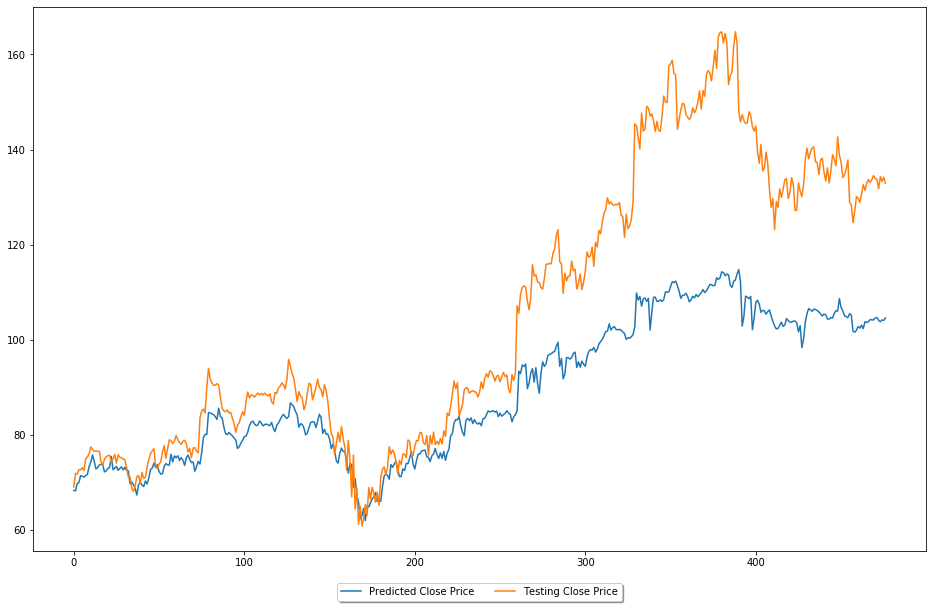

In [58]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()